In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [15]:
sys.path.append('../')

# src imports
from src.load_satellites_data import load_satellites_data, filter_data_tue
from src.kde import kernel_density, get_my_cmap

In [16]:
from tueplots import bundles
from tueplots.constants.color import rgb

### Load Data

In [17]:
path_tue = '../dat/satellite_above_tübingen_90.txt'
path_rome = '../dat/satellite_above_rome_90.txt'

data_rome = load_satellites_data(path_rome)
data_tue = load_satellites_data(path_tue)

Error decoding JSON object 47: Expecting value: line 1 column 1 (char 0)
<class 'pandas.core.frame.DataFrame'>
Index: 138887 entries, 0 to 2941
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   satid          138887 non-null  int64  
 1   satname        138887 non-null  object 
 2   intDesignator  138887 non-null  object 
 3   launchDate     138887 non-null  object 
 4   satlat         138887 non-null  float64
 5   satlng         138887 non-null  float64
 6   satalt         138887 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 8.5+ MB
Error decoding JSON object 48: Expecting value: line 1 column 1 (char 0)
<class 'pandas.core.frame.DataFrame'>
Index: 147717 entries, 0 to 3127
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   satid          147717 non-null  int64  
 1   satname        147717 non-null  object 
 

### Filter Satellites by categories (Starlink and more)

In [18]:
data_tue['is_starlink'] = data_tue['satname'].apply(lambda x: 1 if 'STARLINK' in x else 0)
data_tue['is_cosmos'] = data_tue['satname'].apply(lambda x: 1 if 'COSMOS' in x else 0)
data_tue['is_usa'] = data_tue['satname'].apply(lambda x: 1 if 'USA' in x else 0)
# data_tue.info()
print(data_tue['is_starlink'].value_counts())
print(data_tue['is_cosmos'].value_counts())
print(data_tue['is_usa'].value_counts())

data_tue_starlink = data_tue[data_tue['is_starlink'] == 1]
data_tue_cosmos = data_tue[data_tue['is_cosmos'] == 1]
data_tue_usa = data_tue[data_tue['is_usa'] == 1]

is_starlink
0    135323
1     12394
Name: count, dtype: int64
is_cosmos
0    130634
1     17083
Name: count, dtype: int64
is_usa
0    143127
1      4590
Name: count, dtype: int64


In [19]:
# Filter Tübingen data with spherical distance
data_tue_masked = filter_data_tue(data_tue)
data_tue_starlink_masked = filter_data_tue(data_tue_starlink)
data_tue_cosmos_masked = filter_data_tue(data_tue_cosmos)
data_tue_usa_masked = filter_data_tue(data_tue_usa)

categories = {
    "All": data_tue_masked,
    "Starlink": data_tue_starlink_masked, 
    "COSMOS": data_tue_cosmos_masked, 
    # "USA": data_tue_usa_masked
    }

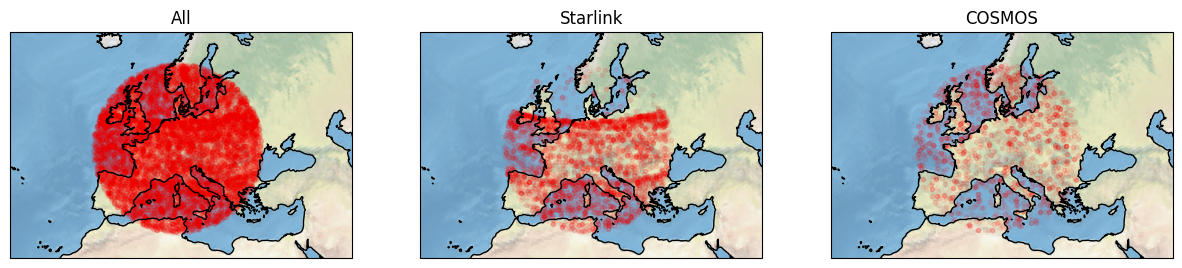

In [20]:
extend = [-25, 45, 30, 65]
data_crs = ccrs.PlateCarree()

# Plot
fig, axs = plt.subplots(
    1, len(categories), 
    subplot_kw={'projection': ccrs.Orthographic(9, 48)},
    figsize=(15, 5))

for i, category in enumerate(categories.values()):
    lats = np.array(category['satlat'])
    longs = np.array(category['satlng'])
    axs[i].stock_img() # background image, removing it somehow cuts off the globe ?
    axs[i].coastlines()
    axs[i].set_extent(extend, crs=ccrs.PlateCarree())
    axs[i].scatter(longs, lats, alpha=.05, color='r', marker='.', transform=data_crs)
    axs[i].set_title(list(categories.keys())[i])
    
plt.show()

## First try for a kernel density estimate
creates a dramatic looking plot, inspired by https://ipython-books.github.io/76-estimating-a-probability-distribution-nonparametrically-with-a-kernel-density-estimation/

In [21]:
# Color map
my_cmap = get_my_cmap()

In [22]:
category = "All"

longs = np.array(categories[category]['satlng'])
lats = np.array(categories[category]['satlat'])

crs_round = ccrs.Orthographic(9, 48)
extend = [-15, 75, 25, 65]
extend_transf = crs_round.transform_points(ccrs.Geodetic(), np.array(extend[:2]), np.array(extend[2:]))[:, :2].T.flatten().tolist()
k = 100
v = kernel_density(longs, lats, projection=crs_round, k=k, extend=extend_transf)

# # Plot the heat map
# ax = plt.axes(projection=crs_round)
# ax.coastlines()
# ax.stock_img() # Add a stock background image
# ax.imshow(
#   v, origin='lower', 
#   extent=extend_transf,
#   interpolation='bilinear',
#   cmap=my_cmap
# )


Exploring the grid to find the value closest to Tübingen

In [23]:
# Transform Tübingen coordinates to Orthographic projection 
tue_lat = 48.782536
tue_long = 9.176995
crs_round = ccrs.Orthographic(9, 48)
tue_transf = crs_round.transform_points(ccrs.Geodetic(), np.array([tue_long]), np.array([tue_lat]))[:, :2].T.flatten().tolist()
print(f'Tübingen coordinates', tue_transf)

k = 100
x0, x1, y0, y1 = extend_transf

# Create the grid.
tx, ty = np.meshgrid(np.linspace(x0, x1, 2 * k),
                        np.linspace(y0, y1, k))

# Find values in the grid that are closest to tue_lat and tue_long
print(f'Last index below tue_lat:', np.max(np.argwhere(tx.ravel() < tue_transf[0])))
print(f'Value of that index:', tx.ravel()[19897])
print(f'Value of next index:', tx.ravel()[19898])
print(f'Trying to understand the grid structure: indices where tx == tx.ravel()[19897]', np.argwhere(tx == tx.ravel()[19897]))

Tübingen coordinates [12982.651420888542, 87123.70286407493]
Last index below tue_lat: 19897
Value of that index: -4815.958495648112
Value of next index: 19373.192749946378
Trying to understand the grid structure: indices where tx == tx.ravel()[19897] [[ 0 97]
 [ 1 97]
 [ 2 97]
 [ 3 97]
 [ 4 97]
 [ 5 97]
 [ 6 97]
 [ 7 97]
 [ 8 97]
 [ 9 97]
 [10 97]
 [11 97]
 [12 97]
 [13 97]
 [14 97]
 [15 97]
 [16 97]
 [17 97]
 [18 97]
 [19 97]
 [20 97]
 [21 97]
 [22 97]
 [23 97]
 [24 97]
 [25 97]
 [26 97]
 [27 97]
 [28 97]
 [29 97]
 [30 97]
 [31 97]
 [32 97]
 [33 97]
 [34 97]
 [35 97]
 [36 97]
 [37 97]
 [38 97]
 [39 97]
 [40 97]
 [41 97]
 [42 97]
 [43 97]
 [44 97]
 [45 97]
 [46 97]
 [47 97]
 [48 97]
 [49 97]
 [50 97]
 [51 97]
 [52 97]
 [53 97]
 [54 97]
 [55 97]
 [56 97]
 [57 97]
 [58 97]
 [59 97]
 [60 97]
 [61 97]
 [62 97]
 [63 97]
 [64 97]
 [65 97]
 [66 97]
 [67 97]
 [68 97]
 [69 97]
 [70 97]
 [71 97]
 [72 97]
 [73 97]
 [74 97]
 [75 97]
 [76 97]
 [77 97]
 [78 97]
 [79 97]
 [80 97]
 [81 97]
 [82 97]
 

In [24]:
print(f'Last index below tue_long:', np.max(np.argwhere(ty.ravel() < tue_transf[1])))
print(f'Value of that index:', ty.ravel()[8599])
print(f'Value of next index:', ty.ravel()[8600])
print(f'Trying to understand the grid structure: indices where ty == ty.ravel()[8599]', np.argwhere(ty == ty.ravel()[8599]))


Last index below tue_long: 8599
Value of that index: 74256.22527816612
Value of next index: 126518.18622397212
Trying to understand the grid structure: indices where ty == ty.ravel()[8599] [[ 42   0]
 [ 42   1]
 [ 42   2]
 [ 42   3]
 [ 42   4]
 [ 42   5]
 [ 42   6]
 [ 42   7]
 [ 42   8]
 [ 42   9]
 [ 42  10]
 [ 42  11]
 [ 42  12]
 [ 42  13]
 [ 42  14]
 [ 42  15]
 [ 42  16]
 [ 42  17]
 [ 42  18]
 [ 42  19]
 [ 42  20]
 [ 42  21]
 [ 42  22]
 [ 42  23]
 [ 42  24]
 [ 42  25]
 [ 42  26]
 [ 42  27]
 [ 42  28]
 [ 42  29]
 [ 42  30]
 [ 42  31]
 [ 42  32]
 [ 42  33]
 [ 42  34]
 [ 42  35]
 [ 42  36]
 [ 42  37]
 [ 42  38]
 [ 42  39]
 [ 42  40]
 [ 42  41]
 [ 42  42]
 [ 42  43]
 [ 42  44]
 [ 42  45]
 [ 42  46]
 [ 42  47]
 [ 42  48]
 [ 42  49]
 [ 42  50]
 [ 42  51]
 [ 42  52]
 [ 42  53]
 [ 42  54]
 [ 42  55]
 [ 42  56]
 [ 42  57]
 [ 42  58]
 [ 42  59]
 [ 42  60]
 [ 42  61]
 [ 42  62]
 [ 42  63]
 [ 42  64]
 [ 42  65]
 [ 42  66]
 [ 42  67]
 [ 42  68]
 [ 42  69]
 [ 42  70]
 [ 42  71]
 [ 42  72]
 [ 42  7

In [25]:
# From that I would guess that tue is closest to v[97, 42]

v_tue = v[97, 42]
print(v_tue)

# Transform back to lat/long
print(ccrs.Geodetic().transform_points(crs_round, np.array([tx.ravel()[19897]]), np.array([ty.ravel()[8599]]))[:, :2].T.flatten().tolist())


2.0180732198908722e-41
[8.934493789959713, 48.667051711193544]


In [26]:
category = "All"
longs_all = np.array(categories[category]['satlng'])
lats_all = np.array(categories[category]['satlat'])

category = "Starlink"
longs_starlink = np.array(categories[category]['satlng'])
lats_starlink = np.array(categories[category]['satlat'])

crs_round = ccrs.Orthographic(9, 48)
extend = [-15, 75, 25, 65]
extend_transf = crs_round.transform_points(ccrs.Geodetic(), np.array(extend[:2]), np.array(extend[2:]))[:, :2].T.flatten().tolist()
k = 100
v_all = kernel_density(longs_all, lats_all, projection=crs_round, k=k, extend=extend_transf)
v_starlink = kernel_density(longs_starlink, lats_starlink, projection=crs_round, k=k, extend=extend_transf)

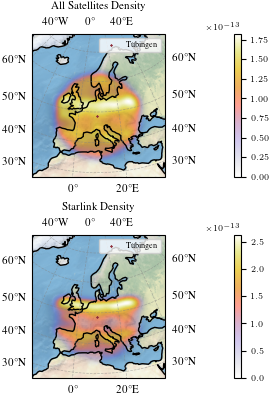

In [37]:
plt.rcParams.update(
    bundles.icml2022(
        column="half",
        nrows=2,
        ncols=1,
        usetex=True,
    )
)

# Plot the coordinates
fig, (ax1, ax2) = plt.subplots(
    2,1,
    subplot_kw={"projection": crs_round}
)

# First subplot with all satellites
ax1.coastlines()
ax1.stock_img() # Add a stock background image
gl = ax1.gridlines(
    draw_labels=True, linewidth=.5, color='gray', alpha=0.5, linestyle='--')
ax1.set_title("All Satellites Density")
# grid = ax.scatter(tx.ravel()[19897], ty.ravel()[8599], color=rgb.tue_blue, marker='x', s=0.5, transform=crs_round)
tue = ax1.scatter(tue_long, tue_lat, color=rgb.tue_red, marker='x', s=0.5, transform=ccrs.PlateCarree())
kde_plot = ax1.imshow(v_all, origin='lower',
            extent=extend_transf,
            interpolation='bilinear',
            cmap=my_cmap)
ax1.legend([tue], ["Tübingen"], loc='upper right')
plt.colorbar(kde_plot)

# Second subplot with Starlink satellites
ax2.coastlines()
ax2.stock_img() # Add a stock background image
gl = ax2.gridlines(
    draw_labels=True, linewidth=.5, color='gray', alpha=0.5, linestyle='--')
ax2.set_title("Starlink Density")
# grid = ax.scatter(tx.ravel()[19897], ty.ravel()[8599], color=rgb.tue_blue, marker='x', s=0.5, transform=crs_round)
tue = ax2.scatter(tue_long, tue_lat, color=rgb.tue_red, marker='x', s=0.5, transform=ccrs.PlateCarree())
kde_plot = ax2.imshow(v_starlink, origin='lower',
            extent=extend_transf,
            interpolation='bilinear',
            cmap=my_cmap)

ax1.legend([tue], ["Tübingen"], loc='upper right')
ax2.legend([tue], ["Tübingen"], loc='upper right')
plt.colorbar(kde_plot, )

plt.savefig("../doc/fig/density_comparison.pdf")
plt.savefig("../doc/fig/density_comparison.png", dpi=300) # for readme

(100, 200)


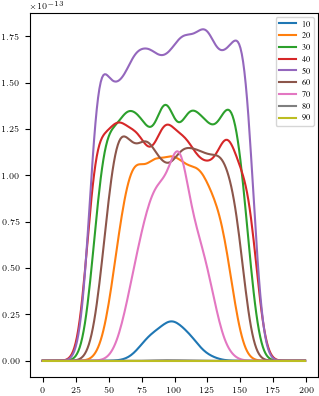

In [28]:
type(v)
print(v.shape)

hs = [10, 20, 30, 40, 50, 60, 70, 80, 90]

for h in hs:
    plt.plot(np.arange(200), v[h,:])
    plt.legend(hs)


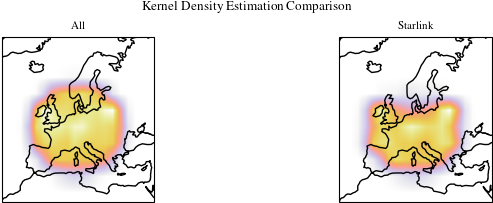

In [29]:
# data
categories = {
    "All": data_tue_masked,
    "Starlink": data_tue_starlink_masked, 
    # "COSMOS": data_tue_cosmos_masked, 
    # "USA": data_tue_usa_masked
}

# kde variables
crs_round = ccrs.Orthographic(9, 48)
extend = [-15, 75, 25, 65]
extend_transf = crs_round.transform_points(ccrs.Geodetic(), np.array(extend[:2]), np.array(extend[2:]))[:, :2].T.flatten().tolist()
k = 10

plt.rcParams.update(
    bundles.icml2022(
        column="full",
        nrows=1,
        ncols=2,
        usetex=True,
    )
)

# Plot
fig, axs = plt.subplots(
    1, 2, 
    subplot_kw={'projection': crs_round}
)

axs.flatten()
fig.suptitle("Kernel Density Estimation Comparison")

for i, category in enumerate(categories.values()):
    
    # Calculate the kernel density estimate for each category
    lats = np.array(category['satlat'])
    longs = np.array(category['satlng'])
    v = kernel_density(longs, lats, projection=crs_round, k=k, extend=extend_transf)

    #axs[i].stock_img() 
    axs[i].coastlines()
    # gl = ax[i].gridlines(
    #     draw_labels=True, linewidth=.5, color='gray', alpha=0.5, linestyle='--'
    # )
    axs[i].imshow(
        v, origin='lower', extent=extend_transf, interpolation='bilinear', cmap=my_cmap
    )
    
    axs[i].set_title(list(categories.keys())[i])
    

plt.savefig("../doc/fig/kernel_density_estimation_comparison.pdf")

plt.show()

C:\Users\timol\AppData\Local\Temp\ipykernel_16020\3441549948.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


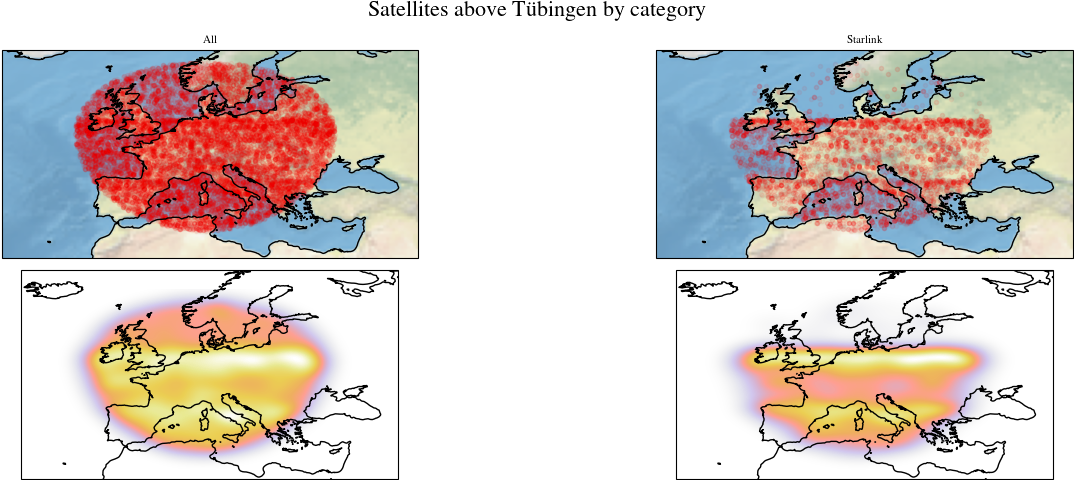

In [30]:
# data
categories = {
    "All": data_tue_masked,
    "Starlink": data_tue_starlink_masked, 
    # "COSMOS": data_tue_cosmos_masked, 
    # "USA": data_tue_usa_masked
}

# kde variables
extend = [-25, 45, 30, 65]
k = 100
crs = ccrs.PlateCarree()

# Plot
fig, axs = plt.subplots(
    2, 2, 
    subplot_kw={'projection': crs},
    figsize=(15, 5))
# axs.flatten()
fig.suptitle("Satellites above Tübingen by category", fontsize=16)

data_crs = ccrs.PlateCarree()
for i, category in enumerate(categories.values()):
    lats = np.array(category['satlat'])
    longs = np.array(category['satlng'])
    
    # Plot point clouds
    axs[0][i].stock_img() 
    axs[0][i].coastlines()
    axs[0][i].scatter(longs, lats, alpha=.05, color='r', marker='.', transform=crs)
    axs[0][i].set_extent(extend, crs=crs)
        
    # Plot KDE
    v = kernel_density(longs, lats, projection=crs, k=k, extend=extend)
    axs[1][i].coastlines()
    axs[1][i].set_extent(extend)
    axs[1][i].imshow(
        v, origin='lower', extent=extend, interpolation='bilinear', cmap=my_cmap
    )
    
    # Set titles and axis labels
    axs[0][i].set_title(list(categories.keys())[i])
    
axs[0][0].set_ylabel("Sample Points")
axs[0][1].set_ylabel("Kernel Density Estimation")
    
plt.tight_layout()
plt.show()

In [31]:
# Load json data
path_SL = '../dat/satellite_above_tue_90_5sek.txt'
data_SL = load_satellites_data(path_SL, random=False)

# Filter by starlink satellites
data_SL['is_starlink'] = data_SL['satname'].apply(lambda x: 1 if 'STARLINK-2' in x else 0)
data_SL = data_SL[data_SL['is_starlink'] == 1]
data_SL.shape


Error decoding JSON object 136: Expecting value: line 1 column 1 (char 0)
<class 'pandas.core.frame.DataFrame'>
Index: 419370 entries, 0 to 3120
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   satid          419370 non-null  int64  
 1   satname        419370 non-null  object 
 2   intDesignator  419370 non-null  object 
 3   launchDate     419370 non-null  object 
 4   satlat         419370 non-null  float64
 5   satlng         419370 non-null  float64
 6   satalt         419370 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 25.6+ MB


(5235, 8)

In [32]:
unique_names, counts = np.unique(data_SL['satname'], return_counts=True)
print(unique_names)
np.max(counts), len(unique_names)

['STARLINK-2000' 'STARLINK-2001' 'STARLINK-2002' 'STARLINK-2003'
 'STARLINK-2004' 'STARLINK-2006' 'STARLINK-2012' 'STARLINK-2014'
 'STARLINK-2015' 'STARLINK-2026' 'STARLINK-2028' 'STARLINK-2029'
 'STARLINK-2030' 'STARLINK-2031' 'STARLINK-2032' 'STARLINK-2040'
 'STARLINK-2041' 'STARLINK-2045' 'STARLINK-2049' 'STARLINK-2050'
 'STARLINK-2052' 'STARLINK-2054' 'STARLINK-2064' 'STARLINK-2076'
 'STARLINK-2077' 'STARLINK-2088' 'STARLINK-2093' 'STARLINK-2097'
 'STARLINK-2098' 'STARLINK-2099' 'STARLINK-2103' 'STARLINK-2105'
 'STARLINK-2111' 'STARLINK-2116' 'STARLINK-2117' 'STARLINK-2127'
 'STARLINK-2133' 'STARLINK-2134' 'STARLINK-2139' 'STARLINK-2142'
 'STARLINK-2145' 'STARLINK-2155' 'STARLINK-2166' 'STARLINK-2225'
 'STARLINK-2228' 'STARLINK-2233' 'STARLINK-2235' 'STARLINK-2245'
 'STARLINK-2250' 'STARLINK-2303' 'STARLINK-2457' 'STARLINK-2477'
 'STARLINK-2495' 'STARLINK-2515' 'STARLINK-2519' 'STARLINK-2520'
 'STARLINK-2521' 'STARLINK-2523' 'STARLINK-2524' 'STARLINK-2527'
 'STARLINK-2528' 'STARLIN

(91, 107)

In [33]:
np.unique(data_SL['satname'], return_counts=True)[0][19]

'STARLINK-2050'

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 2579 to 2572
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   satid          91 non-null     int64  
 1   satname        91 non-null     object 
 2   intDesignator  91 non-null     object 
 3   launchDate     91 non-null     object 
 4   satlat         91 non-null     float64
 5   satlng         91 non-null     float64
 6   satalt         91 non-null     float64
 7   is_starlink    91 non-null     int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 6.4+ KB


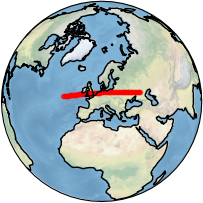

In [34]:
data_SL_2050 = data_SL[data_SL['satname'] == 'STARLINK-2050']
data_SL_2050.info()

# Plot all timesteps of a single satellite
data_crs = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.Orthographic(9, 48))
ax.stock_img() # background image, removing it somehow cuts off the globe ?
ax.coastlines()
ax.scatter(np.array(data_SL_2050['satlng']), np.array(data_SL_2050['satlat']), alpha=.5, color='r', marker='.', transform=data_crs)

Subset of 2503 starlink satellites above Tübingen


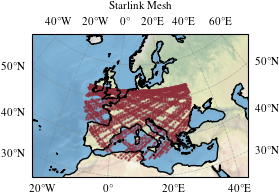

In [35]:
data_SL = filter_data_tue(data_SL)

longs = np.array(data_SL['satlng'])
lats = np.array(data_SL['satlat'])
print(f"Subset of {len(longs)} starlink satellites above Tübingen")

extend = [-25, 45, 30, 65]

# Plot
crs = ccrs.PlateCarree()
crs_globe = ccrs.Orthographic(9, 48)

plt.rcParams.update(
    bundles.icml2022(
        column="half",
        nrows=1,
        ncols=1,
        usetex=True,
    )
)

fig, ax = plt.subplots(
    1, 1, 
    subplot_kw={"projection":crs_globe}
)

ax.stock_img() # background image, removing it somehow cuts off the globe ?
ax.coastlines()
gl = ax.gridlines(
    draw_labels=True, linewidth=.5, color='gray', alpha=0.5, linestyle='--'
)
ax.scatter(longs, lats, color=rgb.tue_red, alpha=.75, s=.5, transform=data_crs)
ax.set_extent(extend, crs=ccrs.PlateCarree())

ax.set_title("Starlink Mesh")

plt.savefig("../doc/fig/starlink_mesh.pdf")


In [36]:
# proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=50.0)
# ax = plt.axes(projection=proj)
# ax.add_feature(cartopy.feature.LAND)
# ax.add_feature(cartopy.feature.OCEAN)
# ax.add_feature(cartopy.feature.COASTLINE) #, edgecolor="brown")
# ax.gridlines()
# plt.tight_layout()
# plt.show() ; plt.close()
